<a href="https://colab.research.google.com/github/varuncanamedi3301/UNISYS-Project/blob/main/Server.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install --extra-index-url https://google-coral.github.io/py-repo tflite_runtime

Looking in indexes: https://pypi.org/simple, https://google-coral.github.io/py-repo
     |████████████████████████████████| 1.5 MB 5.4 MB/s 


In [ ]:
! pip install paho-mqtt

     |████████████████████████████████| 101 kB 3.7 MB/s 
  Created wheel for paho-mqtt: filename=paho_mqtt-1.5.1-py3-none-any.whl size=61566 sha256=9ac217a985c4b7674c4de1806839c80c203df4d6dd25d1ea3c74b94bb7c80cbc
  Stored in directory: /root/.cache/pip/wheels/c9/be/2a/883db47312c70ef7ffcaff281f3294e3075f62da075474d4bb
Successfully built paho-mqtt


In [ ]:
import tflite_runtime
from tflite_runtime.interpreter import Interpreter

print(tflite_runtime.__version__)
print(tflite_runtime.interpreter.Interpreter)

2.5.0.post1
<class 'tflite_runtime.interpreter.Interpreter'>


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
directory = '/content/drive/MyDrive/TFlite_model/'
model_path = directory + "model.tflite"
label_path = directory + "model_labels.txt"
image_path = directory + "subject_15_original_subject15.wink.jpg_d705a1b9-c87c-49f7-bc25-44a4d3e33e05.jpg"

In [ ]:
data_base = '/content/drive/MyDrive/Access_Data.db'

In [ ]:
import cv2
import numpy as np
import sqlite3
import time
from skimage import color
from skimage.feature import hog
import matplotlib.pyplot as plt
from sqlite3 import Error
import datetime
from datetime import date

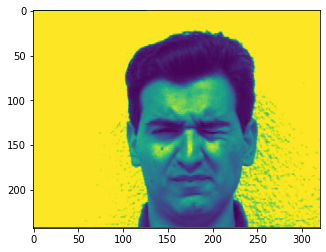

In [ ]:
import matplotlib.pyplot as plt
photo=plt.imread(image_path)
plt.imshow(photo)

# LOADING THE TFLITE MODEL

In [ ]:
interpreter = Interpreter(model_path)
print("Model Loaded Successfully.")
interpreter.allocate_tensors()

Model Loaded Successfully.


In [ ]:
print("Details about the input tensors:\n   ", interpreter.get_input_details())
print("There exist {num} input tensor(s).".format(num=len(interpreter.get_input_details())))
print("   Type:", type(interpreter.get_input_details()), end="\n\n")

print("Details about the first input tensor:\n  ", interpreter.get_input_details()[0])
print("   Type:", type(interpreter.get_input_details()[0]), end="\n\n")

print("Shape of the first input tensor:\n   ", interpreter.get_input_details()[0]['shape'])
print("   Type:", type(interpreter.get_input_details()[0]['shape']), end="\n\n")

a,b = interpreter.get_input_details()[0]['shape']
print("input shape =",(a,b))

Details about the input tensors:
    [{'name': 'input_1', 'index': 0, 'shape': array([    1, 64800], dtype=int32), 'shape_signature': array([   -1, 64800], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
There exist 1 input tensor(s).
   Type: <class 'list'>

Details about the first input tensor:
   {'name': 'input_1', 'index': 0, 'shape': array([    1, 64800], dtype=int32), 'shape_signature': array([   -1, 64800], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
   Type: <class 'dict'>

Shape of the first input tensor:
    [    1 64800]
   Type: <class 'numpy.ndarray'>

input shape = (1, 64800)


# READ IMAGE AND EXTRACT THE HOG FEATURES

In [ ]:
image = cv2.imread(image_path)
image = cv2.resize(image, (128,128))

In [ ]:
fd,hog_image = hog(image, orientations=8, pixels_per_cell=(4,4),cells_per_block=(3, 3),block_norm= 'L2',visualize=True)

In [ ]:
fd = fd.reshape(1,64800)

# DEFINING PROCEDURES TO CLASSIFY THE IMAGE AND UPDATE THE ATTENDANCE LOG

In [ ]:
def set_input_tensor(interpreter, image):

  tensor_index = interpreter.get_input_details()[0]['index']
  print("Index of the input tensor: ", tensor_index, end="\n\n")
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor = image

def classify_image(interpreter, image):
  # Call the invoke() method from inside a function to avoid this RuntimeError: reference to internal data in the interpreter in the form of a numpy array or slice.
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  scores = interpreter.get_tensor(output_details['index'])[0]
  max_score_index = scores.argmax()
  return max_score_index

def sql_fetch(Gate, id_var):
    record=c.execute('SELECT Name, G1, G2, G3 FROM employees where id=?', (id_var,))
    rows = c.fetchall()
    for row in rows:
        if Gate == 'Gate1':
            op = row[1]
        elif Gate == 'Gate2':
            op = row[2]
        else:
            op = row[3]
    return op,row[0]

def update_log(i_d, name, gate, access):
    x = datetime.datetime.now()
    current_time= x. strftime("%H:%M:%S")
    today= date.today()
    entities = (i_d, name, current_time, today, gate, access)
    c.execute('INSERT INTO employees_logf(ID, Name, Intime, Date, Gate, Access) VALUES(?, ?, ?, ?, ?, ?)', entities)
    db_conn.commit()
    print("Attendance log updated")

def sql_connect():
    try:
        db_conn = sqlite3.connect(data_base)
        c = db_conn.cursor()
        print("Connection is established")
        
    except Error:
        print('Error in Connecting to database')

In [ ]:
#set_input_tensor(interpreter, image)

Index of the input tensor:  0



In [ ]:
label_id = classify_image(interpreter, image)

In [ ]:
with open(label_path, 'r') as f:
  labels = [line.strip() for i, line in enumerate(f.readlines())]

In [ ]:
classification_label = labels[label_id].capitalize()

print("Image Label:", classification_label)

Image Label: Subject_1


In [ ]:
Gate = 'Gate1'

In [ ]:
sql_connect()
Access_status, Name = sql_fetch(Gate,classification_label)

Connection is established


# UPDATING THE ATTENDANCE LOG AND DISPLAYING THE RESULTS

In [ ]:
update_log(classification_label, Name, Gate, Access_status)

Attendance log updated


In [ ]:
import pandas as pd
pd.read_sql("SELECT * FROM employees_logf", db_conn)

,ID,Name,Intime,Date,Gate,Access
0,Subject_15,Shashank S,12:59:47,2021-08-06,Gate1,1
1,Subject_15,Shashank S,13:00:39,2021-08-06,Gate1,1
2,Subject_15,Shashank S,13:02:49,2021-08-06,Gate1,1
3,Subject_15,Shashank S,13:04:15,2021-08-06,Gate1,1
